# Demo v2 

In [1]:
#Set up environment
import os
import scipy.signal
import math
import json
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Add Pulsar QRM interface
from pulsar_qrm.pulsar_qrm import pulsar_qrm
from pulsar_qcm.pulsar_qcm import pulsar_qcm

In [3]:
qcm = pulsar_qcm("qcm0", "192.168.0.3", debug=1)
qcm.get_idn()

{'manufacturer': 'Qblox',
 'device': 'Pulsar QCM',
 'serial_number': '',
 'build': {'firmware': {'version': '0.1.0',
   'date': '04/08/2020-07:03:35',
   'hash': '0xD12A1BA',
   'dirty': False},
  'kernel_mod': {'version': '0.1.0',
   'date': '04/08/2020-12:27:50',
   'hash': '0x1128E33B',
   'dirty': True},
  'software': {'version': '0.1.0',
   'date': '04/08/2020-12:27:50',
   'hash': '0x1128E33B',
   'dirty': True}}}

In [4]:
#Connect to device over ethernet
qrm = pulsar_qrm("qrm0", "192.168.0.2", debug=1)
qrm.get_idn()

{'manufacturer': 'Qblox',
 'device': 'Pulsar QRM',
 'serial_number': '',
 'build': {'firmware': {'version': '0.1.0',
   'date': '06/08/2020-13:19:30',
   'hash': '0x3EF6A1FE',
   'dirty': True},
  'kernel_mod': {'version': '0.1.0',
   'date': '06/08/2020-13:19:30',
   'hash': '0x3EF6A1FE',
   'dirty': True},
  'software': {'version': '0.1.0',
   'date': '06/08/2020-13:19:30',
   'hash': '0x3EF6A1FE',
   'dirty': True}}}

In [5]:
qrm.stop_sequencer()
qcm.stop_sequencer()

In [6]:
#Get system status
print(qrm.get_system_status())
print("FPGA temp;    curr: {}, max: {}".format(qrm.get_current_fpga_temperature(),    qrm.get_maximum_fpga_temperature()))
print("Carrier temp; curr: {}, max: {}".format(qrm.get_current_carrier_temperature(), qrm.get_maximum_carrier_temperature()))
print("AFE temp;     curr: {}, max: {}".format(qrm.get_current_afe_temperature(),     qrm.get_maximum_afe_temperature()))

{'status': 'OKAY', 'flags': []}
FPGA temp;    curr: 52, max: 55
Carrier temp; curr: 38, max: 39
AFE temp;     curr: 43, max: 44


In [7]:
from quantify.sequencer.types import Schedule, Operation
from quantify.sequencer.gate_library import Reset, Measure, CNOT, CZ, Rxy, X90, X
from quantify.sequencer.pulse_library import IdlePulse
from quantify.sequencer.backends.pulsar_backend import pulsar_assembler_backend, configure_pulsar_sequencers
from quantify.sequencer.backends.visualization import pulse_diagram_plotly
from quantify.sequencer.resources import QubitResource, CompositeResource, Pulsar_QCM_sequencer, Pulsar_QRM_sequencer
from quantify.sequencer.compilation import add_pulse_information_transmon, determine_absolute_timing

In [8]:
DEVICE_TEST_CFG = {
    "qubits":
    {
        "q0": {"mw_amp180": 0.6, "mw_motzoi": -0.25, "mw_duration": 30e-9,
               "mw_modulation_freq": 50e6, "mw_ef_amp180": 0.87, "mw_ch": "qcm0.s0",
               "ro_ch": "qrm0.s0", "ro_pulse_amp": 0.5, "ro_pulse_modulation_freq": 0,
               "ro_pulse_type": "square", "ro_pulse_duration": 150e-9,
               "ro_acq_delay": 120e-9, "ro_acq_integration_time": 2500e-9,
               "ro_acq_weigth_type": "SSB",
               "init_duration": 250e-6
               }
    },
    "edges": {}
}

In [9]:
sched = Schedule('sched')
q0 = QubitResource('q0')

sched.add(Measure(q0.name), label='measurement')
sched.add(X(q0.name), rel_time=120e-9, ref_op='measurement', ref_pt='start')
for t in np.linspace(20e-9, 100e-9, 4):
    sched.add(X(q0.name), rel_time=t)

qcm0_s0 = Pulsar_QCM_sequencer('qcm0.s0', instrument_name='qcm0', seq_idx=0)
qrm0_s0 = Pulsar_QRM_sequencer('qrm0.s0', instrument_name='qrm0', seq_idx=0)

sched.add_resources([q0, qrm0_s0, qcm0_s0])

sched = add_pulse_information_transmon(sched, DEVICE_TEST_CFG)
sched = determine_absolute_timing(sched)

seq_config_dict = pulsar_assembler_backend(sched, debug=True)

In [10]:
configure_pulsar_sequencers(seq_config_dict)
qrm.set("sequencer0_trigger_mode_acq_path0", False)
qrm.set("sequencer0_trigger_mode_acq_path1", False)

In [11]:
#Start the sequencers
qrm.arm_sequencer()
qcm.arm_sequencer()

qrm.start_sequencer()
qcm.start_sequencer()

In [12]:
time.sleep(1.0)

In [13]:
#Stop the sequencers
qcm.stop_sequencer()
qrm.stop_sequencer()

In [14]:
#Get acquisition
seq = 0
qrm.delete_acquisitions(seq)
qrm.store_acquisition(seq, "meas_0", 2600)
acq = qrm.get_acquisitions(seq)

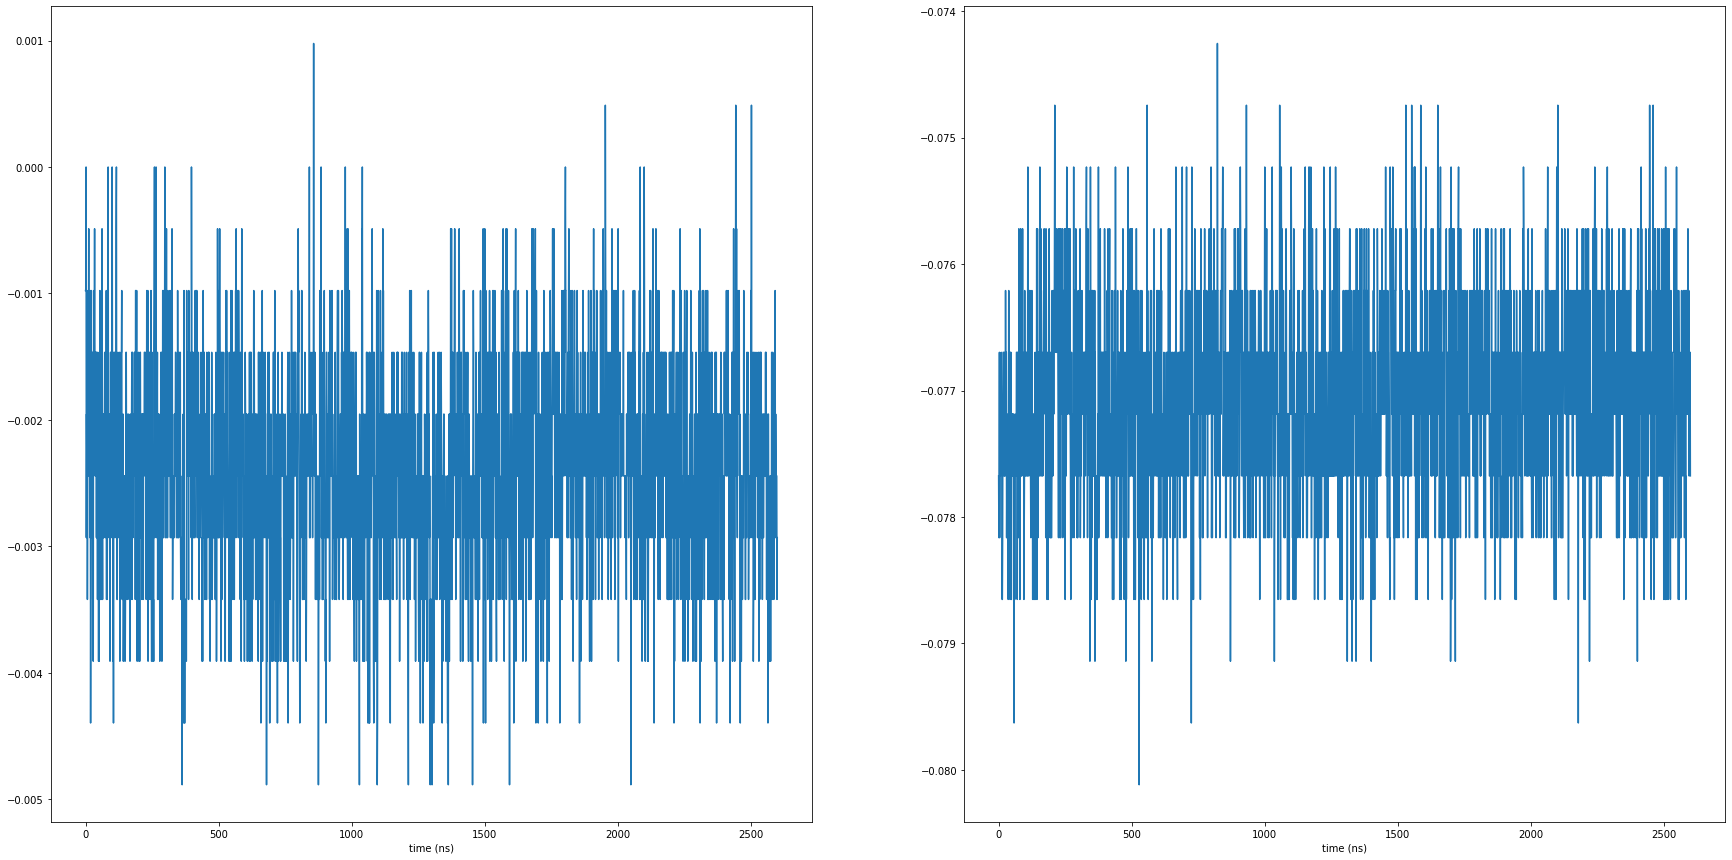

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(30,15))
ax[0].plot(acq["meas_0"]["path_0"]["data"])
ax[0].set_xlabel('time (ns)')
ax[1].plot(acq["meas_0"]["path_1"]["data"])
ax[1].set_xlabel('time (ns)')
plt.show()